In this notebook we implement CNN2D images model.

# Libraries

In [3]:
import numpy as np
import pandas as pd
import os
import time
import cv2
from datetime import date
import matplotlib.pyplot as plt
import tensorflow as tf
import multiprocessing as mp
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import johnsonsu, poisson

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels

import keras.backend as K
from keras import optimizers, models, regularizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# CNN Functions

In [17]:
class cnn_functions:

  """
  - Learning Curves
  - Plot ROC curves and Confusion Matrices
  - Generate report.txt
  - Training data generator
  - Test data generator
  """

  def plot_learn_curves(history, time, title, save=False):
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
      
    # Accuracy
    axs[0].plot(history.history['accuracy'], linestyle='dashed')
    axs[0].plot(history.history['val_accuracy'], linestyle='dashed')
    axs[0].legend(['Train', 'Valid'], loc='upper left')
    axs[0].set_title('Accuracy')
        
    # Loss
    axs[1].plot(history.history['loss'], linestyle='dashed')
    axs[1].plot(history.history['val_loss'], linestyle='dashed')
    axs[1].legend(['Train', 'Valid'], loc='upper left')
    axs[1].set_title('Loss')
      
    fig.text(0.52, 0.02, 'Epoch', fontsize=14, ha='center', va='center')
    fig.text(0.22, 0.02, 'Elapsed %.3f seconds.' % time, fontsize=10,
             ha='center', va='center')
    fig.suptitle(title, y=0.97, fontsize=14, ha='center', va='center')

    if save:
      fig.savefig(dir_name + 'learning_curves.png')

    plt.show()

################################################################################


  def plot_roc_cm(y_true, probs, dir_name, save=False):
    
    y_pred = pd.DataFrame(probs).idxmax(axis=1)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))


    ########## ROC curves

    fpr, tpr, thresholds = roc_curve(y_true, probs[:, 1])
    auc = roc_auc_score(y_true, probs[:, 1])
        
    ax[0].plot([0, 1], [0, 1], 'k--')
    ax[0].plot(fpr, tpr, label="AUC: %.3f" % auc, color='C1', linewidth=3)
    ax[0].legend(loc='best')
    ax[0].set_title('ROC Curve', fontsize=12)
    ax[0].set_xlabel('False Positive Rate', fontsize=12)
    ax[0].set_ylabel('True Positive Rate', fontsize=12)


    ########## Confusion Matrix
      
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
      
    # Choose color
    cmap = plt.cm.GnBu  
        
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fmt = 'd'
    norm_fmt = '.3f'
          
    im = ax[1].imshow(norm_cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    ax[1].figure.colorbar(im, ax=ax[1])
      
    # We want to show all ticks...
    ax[1].set(xticks=np.arange(cm.shape[1]),
              yticks=np.arange(cm.shape[0]),
              xticklabels=['Frowny', 'Smiley'],
              yticklabels=['Frowny', 'Smiley'])
      
    ax[1].set_title('Confusion Matrix', fontsize=12)
    ax[1].set_ylabel('True Label', fontsize=12)
    ax[1].set_xlabel('Predicted Label', fontsize=12)

    # Loop over data dimensions and create text annotations.
    thresh = 0.65
    for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
        ax[1].text(j, i, format(norm_cm[i, j], norm_fmt),
                   ha="center", va="baseline",
                   color="white" if norm_cm[i, j] > thresh else "black",
                   fontsize=12)
        ax[1].text(j, i, '\n\n\n' +
                   format(cm[i, j], fmt) + '/' +
                   format(np.sum(cm[i, :]), fmt),
                   ha="center", va="center",
                   color="white" if norm_cm[i, j] > thresh else "black",
                   fontsize=10)


    acc = accuracy_score(y_true, y_pred)

    fig.suptitle('Accuracy = {}\n'.format(acc), y=0.95, fontsize=16)        
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save:
      fig.savefig(dir_name + 'scores.png')

    plt.show()
    

################################################################################

  def report(report_comments):

    """
    Report the model in a .txt document
    This is useful to recover the model settings as well as the images
    hyperparameters used to train the model.
    - report_comments: general, additional comments - list with string
    """

    # Create txt report of the model
    txt = open(dir_name + 'report.txt', 'w+')

    txt.write('Date: {}'.format(date.today()))

    txt.write('\n\nModel: CNN2D images')
    txt.write('\n\nTraining time elapsed: {}'.format(elapsed_train))

    txt.write('\n\nComments: {}'.format(report_comments))

    txt.write('\n\n### Model settings')
    txt.write('\nCompile Parameters: {}'.format(cnn_model_settings.compile_params))
    txt.write('\n#Callbacks Parameters')
    txt.write('\nEarly Stopping: {}'.format(cnn_model_settings.earlystop_params))
    txt.write('\nReduce LR on Plateau: {}'.format(cnn_model_settings.reduceLR_params))

    txt.write('\n\n### Validation settings')
    txt.write('\nValidation Split Parameters: {}'.format(data_preprocess.val_params))

    txt.write('\n\n### Images settings')
    txt.write('\nImages Parameters: {}'.format(img_param))

    txt.close()

################################################################################

  # Images Generator
  def generator(X, y, batch_size, shuffle):

    """
    Generates batches of images 'on the fly' during training.
    :param X: input data
    :type X: numpy.ndarray(shape=(, 2n))
    :param y: labels
    :type y: numpy.ndarray(shape=(,))
    :param batch_size: size of the batch
    :type batch_size: int
    :param shuffle: choose if shuffle or not
    :type shuffle: boolean
    """

    X = np.array(X)
    y = np.array(y)

    number_of_batches = int(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])

    if shuffle:
          np.random.shuffle(sample_index)
    while True:
      batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
      
      X_batch = cnn_functions.build_images(X[batch_index,:], **img_param)
      y_batch = y[batch_index]
      
      X_batch = X_batch.reshape(X_batch.shape[0],
                                X_batch.shape[1],
                                X_batch.shape[2], 1).astype('float32')

      y_batch = np_utils.to_categorical(y_batch, num_classes=2)
      counter += 1
      
      yield X_batch, y_batch
      
      if (counter == number_of_batches):
        if shuffle:
          np.random.shuffle(sample_index)
        counter = 0

################################################################################      
        
  def generator_test(X, batch_size):

    """
    Generates batches of images 'on the fly' during prediction.
    :param X: input data
    :type X: numpy.ndarray(shape=(, 2n))
    :param batch_size: size of the batch
    :type batch_size: int
    """

    X = np.array(X)

    number_of_batches = int(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    
    while True:
      batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
      
      X_batch = cnn_functions.build_images(X[batch_index,:], **img_param)
      X_batch = X_batch.reshape(X_batch.shape[0],
                                X_batch.shape[1],
                                X_batch.shape[2], 1).astype('float32')
      
      counter += 1
      yield X_batch
      if (counter == number_of_batches):
        counter = 0

################################################################################

  def build_images(x, n_cols, n_rows, up_bound, low_bound,
                  thr=None, vary_threshold=False):

      """
      Gauss version
      - x is the vector of measurements and errors:
        ([m_1,m_2,...,m_n,err_1,err_2,...,err_n])
      - n_cols is the number of columns, i.e., the number of features (measurements)
      - n_rows is the number of rows in the image
      - up_bound/low_bound are the upper and lower boundaries of the image.
        The limits of the image mean + up_bound and mean - low_bound.
        For symmetric probability distributions it is ok to have up_bound = low_bound.
      """

      x = np.array(x)

      mag = np.array(x[:, :n_cols])
      err = np.array(x[:, n_cols:])

      mag_mean = np.mean(mag, axis=1)

      n_samples = len(mag)
      n_features = len(mag.T)

      vec = np.linspace(mag_mean - low_bound, mag_mean + up_bound, n_rows).T
      vec = vec.reshape(n_samples, n_rows, 1)
      vec_2d = np.tile(vec, n_features)

      mag_2d = mag.reshape(n_samples, 1, n_features)
      err_2d = err.reshape(n_samples, 1, n_features)

      images = ((np.exp(-0.5 * (vec_2d - mag_2d) ** 2 / err_2d ** 2))/
                np.sqrt(2 * np.pi * err_2d ** 2))
      
      # Normalization: set maximum value of each image to one
      images = images / (np.max(images, axis=(1, 2)).reshape(n_samples, 1, 1) *
                        np.ones((1, n_rows, n_cols)))
      
      # Auxiliary variable to compute the maximum value of each column
      aux = (np.max(images, axis=1).reshape(n_samples, 1, n) *
             np.ones(images.shape))

      if vary_threshold:
        images = images/aux
        images[images < thr] = 0
      
      else:
        # set small values to zero (avoid values such as 1e-16)
        images[images/aux < 0.001] = 0
      
      return images

  ################################################################################

  def test_results(model, X):

    """
    - model: CNN weights;
    - X: input features (table);

    Run the model in the data set X.
    X is a table with the features. It is converted into images with
    the generator_test function.
    Returns the predicted scores.
    """

    batch_size = 100
    probs_batch = pd.DataFrame(model.predict(cnn_functions.generator_test(X, batch_size),
                                            steps=int(len(X)/batch_size),
                                            max_queue_size=10, workers=1,
                                            use_multiprocessing=False,
                                            verbose=0))
    
    # There might be remaining objects because of the batch
    if (len(X) % batch_size) != 0: 
      remain_X = X[-(len(X)%batch_size):]
      remain_X = cnn_functions.build_images(remain_X, **img_param)
      remain_X = remain_X.reshape(remain_X.shape[0],
                                    remain_X.shape[1],
                                    remain_X.shape[2], 1).astype('float32')
      probs_remain = pd.DataFrame(model.predict(remain_X))
      
      probs = pd.concat([probs_batch, probs_remain])

    else:
      probs = probs_batch

    return probs

# Data Preprocessing Functions

In [5]:
class data_preprocess:

  val_params = {'test_size': 0.2,
                'random_state': 42,
                'shuffle': True}


  def train_val_set(X, y, validation_params=None):

      """
      Split training set into train and validation in a stratified way.
      Set the parameters in the dictionary 'val_params' above.
      Return train and validation sets with the proper input shape.
      """

      if validation_params == None:
        validation_params = data_preprocess.val_params
      
      # Validation Set
      xtrain, xval, ytrain, yval = train_test_split(X, y, stratify=y,
                                                    **validation_params)
      
      # Convert validation set into images
      xval = cnn_functions.build_images(xval, **img_param)
      xval = xval.reshape(xval.shape[0],
                          xval.shape[1],
                          xval.shape[2], 1).astype('float32')
      yval = np_utils.to_categorical(yval, num_classes=2)
      
      train_set = [xtrain, ytrain]
      val_set = [xval, yval]
            
      return train_set, val_set


  def prepare_data(train, n, validation_params=None):
    """
    Select features, reshape data tensor and run the procedures above.
    """

    ytrain = train['type']
    xtrain = train.iloc[:, :n*2]

    # Split into train and validation
    train_set, val_set = data_preprocess.train_val_set(xtrain, ytrain,
                                                       validation_params)

    data = [train_set, val_set]

    return data

# **Train**

## Load data and set file path

In [ ]:
# Load training set
train = pd.read_csv('smileyfrowny/datasets/train_m200_n20_sig5_dg5.csv')

# Number of features
n = 20

In [ ]:
# Set path to a directory to save the model
study_case = 'baseline'

In [ ]:
# Choose a directory name to save the model weights and results
dir_name = 'images/{}/'.format(study_case)

# Create folder
if os.path.exists(dir_name):
  print('ignoring: FILE EXISTS!')
else:
  os.mkdir(path=dir_name)

## Visualize Images

In [ ]:
import matplotlib
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

def vis_images(img, data):

  plt.figure(figsize=(8, 8))

  plt.imshow(img + 0.001, origin='lower', cmap='GnBu', alpha=1, norm=colors.LogNorm())
  
  cbar = plt.colorbar(shrink=.825, ticks=[0.01, 0.1, 1])
  cbar.ax.tick_params(labelsize=24)
  cbar.ax.set_yticklabels(['0.01', '0.1', '1'])

  plt.tick_params(labelsize=24)
  plt.xlabel('$i$', fontsize=28)

  plt.xticks([0, 4, 9, 14, 19], labels=['1', '5','10','15', '20'])
  plt.yticks([])
  
  plt.show()

In [ ]:
# Choose image parameters
img_param = {'n_cols': n,
             'n_rows': 40,
             'up_bound': 2.5,
             'low_bound': 2.5,
             'thr': 0.001,
             'vary_threshold': False}

# Choose image index
ind = 5

In [ ]:
data_ = train.iloc[ind:ind+1, :-1]

img = cnn_functions.build_images(data_, **img_param)[0]

vis_images(img, data_.iloc[:1])

## Prepare data

In [ ]:
data = data_preprocess.prepare_data(train, n)

## Build model

In [ ]:
class cnn_model_settings:

  compile_params = {'loss': 'binary_crossentropy',
                    'optimizer': 'Adam',
                    'metrics': ['accuracy'],
                    'loss_weights': None,
                    'sample_weight_mode': None, 
                    'weighted_metrics': None, 
                    'target_tensors': None}


  def create_model():

      model = Sequential()

      model.add(Conv2D(32, (5, 5), activation='relu', padding='same',
                       input_shape=(img_param['n_rows'],
                                    img_param['n_cols'],
                                    1)))
      
      model.add(BatchNormalization())
      model.add(MaxPooling2D((int(img_param['n_rows']/10), 2),
                             strides=(int(img_param['n_rows']/10), 2)))
      model.add(Dropout(0.2))
      
      model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D((2, 2), strides=(2, 2)))
      model.add(Dropout(0.4))

      model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D((2, 2), strides=(2, 2)))
      model.add(Dropout(0.4))

      model.add(Flatten())

      model.add(Dense(64, activation='relu'))
      model.add(Dense(2, activation='softmax'))
      
      # Compile model
      model.compile(**cnn_model_settings.compile_params)
      model.summary()
      
      return model

    
  reduceLR_params = {'monitor': 'val_loss',
                     'factor': 0.1,
                     'patience': 10,
                     'verbose': 1,
                     'mode': 'min',
                     'min_delta': 0.0001,
                     'cooldown': 0,
                     'min_lr': 0}

  earlystop_params = {'monitor': 'val_loss',
                      'patience': 16,
                      'min_delta': 0.0001,
                      'verbose': 1,
                      'mode': 'auto',
                      'baseline': None,
                      'restore_best_weights': False}

  logger_params = {'filename': dir_name + 'epochs_results.csv',
                   'separator': ',',
                   'append': False}

  checkpoint_params = {'filepath': dir_name + 'best_acc.h5',
                       'monitor': 'val_accuracy',
                       'mode': 'max',
                       'verbose': 0,
                       'save_best_only': True,
                       'save_weights_only': False,
                       'save_freq': 'epoch'}


  def get_callbacks():

    early_stop = EarlyStopping(**cnn_model_settings.earlystop_params)
    reduce_lr_loss = ReduceLROnPlateau(**cnn_model_settings.reduceLR_params)
    csv_logger = CSVLogger(**cnn_model_settings.logger_params)
    mcp_save = ModelCheckpoint(**cnn_model_settings.checkpoint_params)
      
    return [early_stop, reduce_lr_loss, csv_logger, mcp_save]


  def run_cnn(info):
      
    data, model = info
      
    train, val = data
      
    xtrain, ytrain = train
    xval, yval = val
      
    callbacks = cnn_model_settings.get_callbacks()

    batch_size = 100

    start = time.perf_counter()

    history = model.fit(cnn_functions.generator(xtrain, ytrain, batch_size, False),
                        steps_per_epoch=int(len(xtrain)/batch_size),
                        epochs=500,
                        verbose=1,
                        validation_data=(xval, yval),
                        validation_steps=int(len(xval)/batch_size),
                        callbacks=callbacks)

    elapsed = time.perf_counter() - start
    print('Elapsed %.3f seconds.' % elapsed)
      
    return history, elapsed

In [ ]:
model = cnn_model_settings.create_model()

## Run model

In [ ]:
info = [data, model]
hist, elapsed_train = cnn_model_settings.run_cnn(info)

## Report model

In [ ]:
report_comments = ['smiley-frowny, n = 20, sigma0 = 0.5, delta g = 0.5.']

cnn_functions.plot_learn_curves(hist, elapsed_train,
                                title='CNN2D images', save=True)

cnn_functions.report(report_comments)

## Apply model - validation set

In [ ]:
model = load_model(dir_name + 'best_acc.h5')

In [ ]:
xval, yval = data[1]
yval = pd.DataFrame(yval).idxmax(axis=1).reset_index(drop=True)

In [ ]:
probs_val = model.predict(xval)

In [ ]:
cnn_functions.plot_roc_cm(yval, probs_val, dir_name, save=False)

# Apply model - test set

In [9]:
# Define directory to load model and save the results
dir_name = 'smileyfrowny/images/baseline/'

# Save predictions?
save = True

In [8]:
# Set image parameters (should be the same used to train)
img_param = {'n_cols': 20,
             'n_rows': 40,
             'up_bound': 2.5,
             'low_bound': 2.5,
             'thr': 0.001,
             'vary_threshold': False}

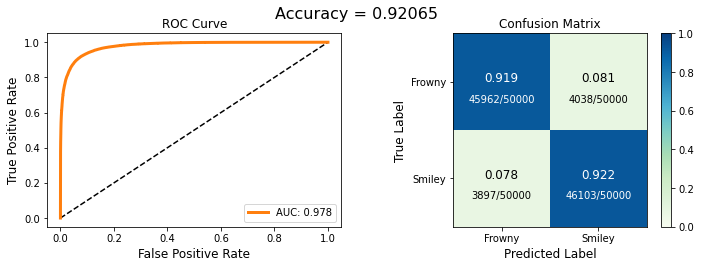

In [18]:
# Load testing set
test = pd.read_csv('smileyfrowny/datasets/test_m100_n20_sig5_dg5.csv')

n = 20

model = load_model(dir_name + 'best_acc.h5')

ytest = test['type']
xtest = test.iloc[:, :n*2]

probs = cnn_functions.test_results(model, xtest).reset_index(drop=True)

cnn_functions.plot_roc_cm(ytest, probs.to_numpy(), dir_name, save=save)
if save:
  pd.DataFrame(probs).to_csv(dir_name + 'probs.csv', index=False)